<a href="https://colab.research.google.com/github/ZYD-9/9x3-Neural_Style_Transfer-Notebook/blob/main/1st_Class_domain_adaptation_for_class_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [ ]:
vgg19 = models.vgg19(pretrained=True).features

# Disable gradient updates
for param in vgg19.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [img for img in os.listdir(directory)
                       if os.path.isfile(os.path.join(directory, img))
                       and img.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.images[idx])
        # Open the image file and convert it to RGB to ensure three channels
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


In [ ]:
class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),  # VGG19 outputs 512x7x7 feature maps
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 2)  # Binary classification: source or target
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        return self.classifier(x)

domain_classifier = DomainClassifier()


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])

wikiart_dataset = CustomDataset('/content/drive/MyDrive/wikiart_dataset/Romanticism/Romanticism', transform=transform)
philippine_dataset = CustomDataset('/content/drive/MyDrive/target Datasets/Class1', transform=transform)

wikiart_loader = DataLoader(wikiart_dataset, batch_size=32, shuffle=True)
philippine_loader = DataLoader(philippine_dataset, batch_size=32, shuffle=True)

In [ ]:
optimizer = optim.Adam(domain_classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    domain_classifier.train()
    for source_data, target_data in zip(wikiart_loader, philippine_loader):
        source_images = source_data
        target_images = target_data

        # Extract features using VGG19
        source_features = vgg19(source_images)
        target_features = vgg19(target_images)

        # Concatenate source and target features and create domain labels
        combined_features = torch.cat([source_features, target_features], 0)
        domain_labels = torch.cat([torch.zeros(source_features.size(0)),
                                   torch.ones(target_features.size(0))], 0).long()

        # Domain classification
        domain_preds = domain_classifier(combined_features)
        loss = criterion(domain_preds, domain_labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 1.2163
Epoch [2/10], Loss: 3.3788
Epoch [3/10], Loss: 1.3970
Epoch [4/10], Loss: 0.6468
Epoch [5/10], Loss: 0.4403
Epoch [6/10], Loss: 0.4714
Epoch [7/10], Loss: 0.2306
Epoch [8/10], Loss: 0.0472
Epoch [9/10], Loss: 0.0705
Epoch [10/10], Loss: 0.1443


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

source_features_flat = source_features.view(source_features.size(0), -1).cpu().detach().numpy()
target_features_flat = target_features.view(target_features.size(0), -1).cpu().detach().numpy()

combined_features_flat = np.concatenate([source_features_flat,target_features_flat],axis = 0)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features_flat)

reduced_source = reduced_features[:len(source_features_flat)]
reduced_target = reduced_features[:len(target_features_flat):]

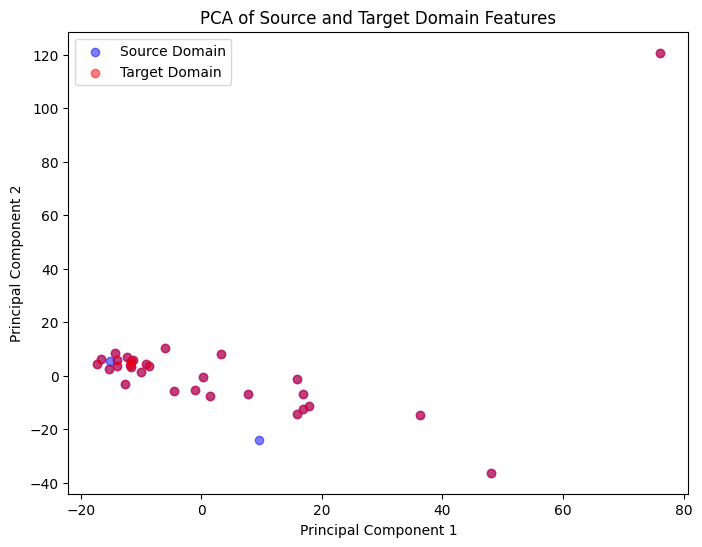

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_source[:, 0], reduced_source[:, 1], c='blue', label='Source Domain', alpha=0.5)
plt.scatter(reduced_target[:, 0], reduced_target[:, 1], c='red', label='Target Domain', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Source and Target Domain Features')
plt.legend()
plt.show()

In [ ]:

torch.save(vgg19.state_dict(), '/content/drive/MyDrive/model/vgg19_fined_tuned.pth')